In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from lib.constants import AMINO_ACID_MAP, AMINO_ACID_MAP_INV
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [ ]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'
# casp_protein_ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
# pdb_codes = ['6T1Z', '7UM1', '7D2O', '7CN6', '7W6B', '7ABW', '6Y4F', '6POO', '6YJ1', '6YA2', '6UV6', '6VQP']
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]
winsizes = [4,5,6,7]
lengths = [4096, 512, 256, 256]
lengths_dict = {w:l for w,l in zip(winsizes, lengths)}
outdir = Path('ml_samples/' + '-'.join(str(l) for l in lengths))
outdir.mkdir(exist_ok=True, parents=True)
all_seqs = []
n_matches = defaultdict(list)
# pdb_codes = [pdb_codes[0]]
for id in pdb_codes:
    if (outdir / f'{id}.pt').exists():
        continue
    try:
        da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
        # da.compute_structure()
        da.load_results()
    except FileNotFoundError as e:
        print(e)
        continue
    if da.af_phi_psi is None:
        continue
    seqs = pd.merge(
        da.xray_phi_psi[['seq_ctxt', 'res', 'phi', 'psi']], 
        da.af_phi_psi[['seq_ctxt', 'phi', 'psi']], 
        on='seq_ctxt', suffixes=('', '_af')
    ).rename(columns={'seq_ctxt': 'seq'})
    if seqs.shape[0] == 0:
        continue
    all_seqs.append(seqs)

    print(seqs.shape, seqs.seq.nunique())
    X = []
    y = []
    x_res = []
    af_phi_psi = []
    for i,row in tqdm(seqs.iterrows()):
        phis = []
        psis = []
        if np.isnan(row.phi) or np.isnan(row.psi) or np.isnan(row.phi_af) or np.isnan(row.psi_af):
            for w in winsizes:
                n_matches[w].append(0)
            continue
        for q in da.queries:
            inner_seq = q.get_subseq(row.seq)
            matches = q.results[q.results.seq == inner_seq][['seq', 'phi', 'psi']]
            n_matches[q.winsize].append(matches.shape[0])
            if matches.shape[0] == 0:
                phis.append(np.zeros(lengths_dict[q.winsize]))
                psis.append(np.zeros(lengths_dict[q.winsize]))
                continue
            phi = matches.phi.values
            psi = matches.psi.values
            if matches.shape[0] >= lengths_dict[q.winsize]:
                phi = np.random.choice(phi, lengths_dict[q.winsize], replace=False)
                psi = np.random.choice(psi, lengths_dict[q.winsize], replace=False)
            else:
                phi = np.pad(phi, (0, lengths_dict[q.winsize] - matches.shape[0]))
                psi = np.pad(psi, (0, lengths_dict[q.winsize] - matches.shape[0]))
            phis.append(phi)
            psis.append(psi)
        phis = np.concatenate(phis)
        psis = np.concatenate(psis)
        if np.sum(phis) == 0: # no matches
            continue
        X.append(np.stack([phis, psis]))
        y.append(np.array([row.phi, row.psi]))
        x_res.append(AMINO_ACID_MAP[row.res])
        af_phi_psi.append([row.phi_af, row.psi_af])
    if len(X) == 0:
        print('No matches for', id)
        continue
    X = np.stack(X)
    y = np.stack(y)
    x_res = F.one_hot(torch.Tensor(x_res).to(torch.int64), num_classes=20)
    af_phi_psi = np.stack(af_phi_psi)
    torch.save((torch.Tensor(X), torch.Tensor(y), x_res, torch.Tensor(af_phi_psi)), outdir / f'{id}.pt')
all_seqs = pd.concat(all_seqs)
for k,v in n_matches.items():
    all_seqs[k] = v
print(all_seqs.describe())
print(all_seqs[winsizes].quantile(0.95))

In [18]:
from scipy.stats import gaussian_kde
from sklearn.cluster import MeanShift

# Precompute KDEs
lengths = [4096, 512, 256, 256]
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
path = Path('ml_samples/'+'-'.join([str(l) for l in lengths]))
samples = [f.stem for f in path.iterdir()]

for sample in samples[1:]:
    X, y, x_res, af = torch.load(path / f'{sample}.pt')
    print(X.shape)
    for Xi in X:
        print(Xi.shape)
        kdepeaks = []
        for i in range(len(s)):
            x = Xi[:,s[i]:(s[i+1] if i < len(s)-1 else None)]
            print(x.shape)
            # x[(x[0] == 0) & (x[1] == 0)] = np.nan
            x = x[:,(x!=0).all(axis=0)]
            print(x.shape)
        break
    break
            # kde = gaussian_kde(x, bw_method=0.5)

            # phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 180), np.linspace(-180, 180, 180))
            # grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
            # probs = kde(grid).reshape(phi_grid.shape)
            # kdepeak = grid[:,probs.argmax()]
            # print(kdepeak, probs.max())

torch.Size([354, 2, 5120])
torch.Size([2, 5120])
torch.Size([2, 4096])
torch.Size([2, 4091])
torch.Size([2, 512])
torch.Size([2, 461])
torch.Size([2, 256])
torch.Size([2, 252])
torch.Size([2, 256])
torch.Size([2, 252])


# Model

In [ ]:
# protein_cache = {}
# max_proteins = 100

# class ProteinDataset(Dataset):
#     def __init__(self, id, path):
#         self.id = id
#         self.path = path
#         X, _, _ = torch.load(self.path / f'{self.id}.pt')
#         self.shape = X.shape

#     def __len__(self):
#         return self.shape[0]

#     def __getitem__(self, i):
#         if self.id in protein_cache:
#             X, y, xres = protein_cache[self.id]
#         else:
#             X, y, xres = torch.load(self.path / f'{self.id}.pt')
#             if len(protein_cache) < max_proteins:
#                 protein_cache[self.id] = (X, y, xres)
#             else:
#                 del protein_cache[list(protein_cache.keys())[0]]
#                 protein_cache[self.id] = (X, y, xres)
#         return X[i], xres[i], y[i]

In [5]:
class ProteinDataset(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.y, self.xres, self.af = torch.load(self.path / f'{id}.pt')
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.y[i]

In [6]:
lengths = [4096, 512, 256, 256]
path = Path('ml_samples/'+'-'.join([str(l) for l in lengths]))
samples = [f.stem for f in path.iterdir()]

from lib.retrieve_data import retrieve_target_list
ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
targetlist = retrieve_target_list()
skip = [targetlist.loc[id, 'pdb_code'].upper() for id in ids]
samples = sorted(list(set(samples) - set(skip)))

train, test = train_test_split(samples, test_size=0.35, random_state=42)
torch.save((train, test), 'ml_data/split.pt')
# train, test = to ch.load('ml_data/split.pt')
train_dataset = ConcatDataset([ProteinDataset(s, path) for s in train])
test_dataset = ConcatDataset([ProteinDataset(s, path) for s in test])
trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset)

(47572, 25179, 72751)

In [7]:
X,xres,af,y = next(iter(trainloader))

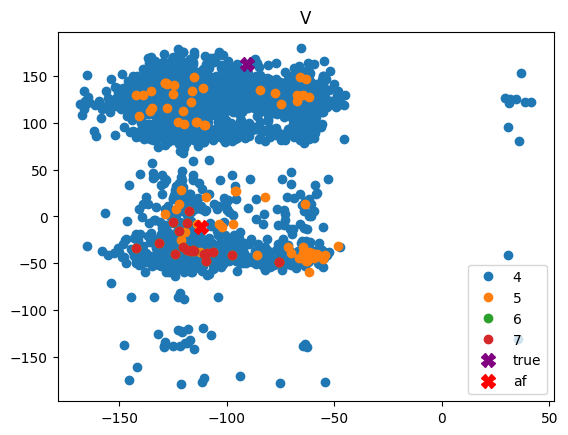

In [8]:
def plot(Xp, y, i, logits=None, logits2=None, res=None, af=None):
    ls = lengths
    Xp = Xp.cpu().clone().detach()
    y = y.cpu().clone().detach()
    Xp[Xp==0] = np.nan
    s = [sum(lengths[:i]) for i,l in enumerate(ls)]
    s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
    plt.plot(Xp[i, 0, s[0]:s[1]], Xp[i, 1, s[0]:s[1]], 'o', label='4')
    plt.plot(Xp[i, 0, s[1]:s[2]], Xp[i, 1, s[1]:s[2]], 'o', label='5')
    plt.plot(Xp[i, 0, s[2]:s[3]], Xp[i, 1, s[2]:s[3]], 'o', label='6')
    plt.plot(Xp[i, 0, s[3]:    ], Xp[i, 1, s[3]:    ], 'o', label='7')
    
    plt.plot(y[i,0],y[i,1], 'X', label='true', color='purple',  markersize=10)
    if res is not None:
        res = res.cpu().clone().detach()
        plt.title(AMINO_ACID_MAP_INV[res[i].argmax().item()])
    if af is not None:
        af = af.cpu().clone().detach()
        plt.plot(af[i,0],af[i,1], 'X', label='af', color='red', markersize=10)
    if logits is not None:
        logits = logits.cpu().clone().detach()
        plt.plot(logits[i,0].detach(),logits[i,1].detach(), 'X', label='pred', color='black', markersize=10)
    if logits2 is not None:
        logits2 = logits2.cpu().clone().detach()
        plt.plot(logits2[i,0].detach(),logits2[i,1].detach(), 'X', label='pred2', color='orange', markersize=10)
    plt.legend()
plot(X,y, 5, res=xres, af=af)

In [9]:
def save_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    torch.save(model.state_dict(), path)
def load_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    model.load_state_dict(torch.load(path))
    return model

In [10]:
from scipy.stats import gaussian_kde

In [11]:
length = sum([l for l in lengths])
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
device = 'cuda:0'
class LSTMNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = 16
        h = self.h
        nl = 2
        p_drop = 0.0
        mlp_h = 8
        # self.lstm1 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        # self.lstm2 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        # self.lstm3 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        # self.lstm4 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        # self.ln1 = nn.LayerNorm(h*8, elementwise_affine=False)
        # self.dropout1 = nn.Dropout(0.05)
        # # self.fc1 = nn.Linear(h*8+20+2, mlp_h)
        # self.ln2 = nn.LayerNorm(mlp_h, elementwise_affine=False)
        # self.dropout2 = nn.Dropout(0.00)
        self.fc1 = nn.Linear(20+2, mlp_h)
        self.fc2 = nn.Linear(mlp_h, 2)

    def forward(self, x, xres, af):
        # x1 = self._sort(x[:,:,s[0]:s[1]].permute(0,2,1))
        # x2 = self._sort(x[:,:,s[1]:s[2]].permute(0,2,1))
        # x3 = self._sort(x[:,:,s[2]:s[3]].permute(0,2,1))
        # x4 = self._sort(x[:,:,s[3]:    ].permute(0,2,1))

        x1 = self.x[:,:,s[0]:s[1]]
        x2 = self.x[:,:,s[1]:s[2]]
        x3 = self.x[:,:,s[2]:s[3]]
        x4 = self.x[:,:,s[3]:    ]
        x = [x1, x2, x3, x4]

        # for i in range(4):
            # kde = gaussian_kde(x[i].flatten())

        # # h = self.lstm1(x1)[1][0]  # num_layers * num_directions, batch, hidden_size
        # # h = h.permute(1,0,2)      # batch, num_layers * num_directions, hidden_size
        # # h = h[:,-2:,:]            # batch, 2, hidden_size (final hidden state of each direction for last layer)
        # # x = h.flatten(1)          # batch, 2*hidden_size
        # x1 = self.lstm1(x1)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        # x2 = self.lstm2(x2)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        # x3 = self.lstm3(x3)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        # x4 = self.lstm4(x4)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        # x = torch.cat([x1,x2,x3,x4], dim=1)
        # x = self.ln1(x)
        # x = torch.cat([x, xres, af], dim=1)

        # x = self.dropout1(x)
        # x = self.fc1(F.relu(x))
        # x = self.ln2(x)
        # x = self.dropout2(x)
        # x = self.fc2(F.relu(x))
        # x = self.fc3(F.relu(x))
        x = torch.cat([xres, af], dim=1) # tmp
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        return x
    
    # def get_encoding(self, x, xres):
    #     x1 = self._sort(x[:,:,s[0]:s[1]].permute(0,2,1))
    #     x2 = self._sort(x[:,:,s[1]:s[2]].permute(0,2,1))
    #     x3 = self._sort(x[:,:,s[2]:s[3]].permute(0,2,1))
    #     x4 = self._sort(x[:,:,s[3]:    ].permute(0,2,1))

    #     x1 = self.lstm1(x1)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
    #     x2 = self.lstm2(x2)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
    #     x3 = self.lstm3(x3)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
    #     x4 = self.lstm4(x4)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
    #     x = torch.cat([x1,x2,x3,x4], dim=1)
    #     x = torch.cat([x1,x2,x3,x4], dim=1)
    #     x = torch.cat([x, xres], dim=1)
    #     return x
    
    def _sort(self, x):
        # idxs = x.sum(dim=2).sort()[1].unsqueeze(-1).expand(-1,-1,2)
        # x = x.gather(1, idxs)
        return x
    
class AngleMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        def diff(x1, x2):
            d = torch.abs(x1 - x2)
            d = torch.minimum(d, 360-d)
            return d
        phi_diff = diff(x[:,0], y[:,0]).unsqueeze(1)
        psi_diff = diff(x[:,1], y[:,1]).unsqueeze(1)
        return torch.mean(torch.hstack([phi_diff, psi_diff])**2)
    
# model = LSTMNet().to(device)
model = nn.DataParallel(LSTMNet()).to(device)
criterion = AngleMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

202

In [27]:
X,xres,af,y = next(iter(trainloader))
print(X.shape, xres.shape, af.shape, y.shape)
model(X.to(device),xres.to(device),af.to(device)).shape

torch.Size([512, 2, 5120]) torch.Size([512, 20]) torch.Size([512, 2]) torch.Size([512, 2])


torch.Size([512, 2])

In [32]:
train_losses = []
test_losses = []
lowest_test_loss = float('inf')
writer = SummaryWriter('tensorboard')
for epoch in (pbar := tqdm(range(1500))):
    losses = []
    model.train()
    for X,xres,af,y in trainloader:
        X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X, xres, af)
        if logits.isnan().sum() > 0:
            raise ValueError('nan')
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,xres,af,y in testloader:
        with torch.no_grad():
            X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
            logits = model(X, xres, af)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))
    if test_losses[-1] < lowest_test_loss:
        lowest_test_loss = test_losses[-1]
        save_model(model, 'ml_data/best_model.pt')
    writer.add_scalars('Loss', {
        'train': train_losses[-1],
        'test': test_losses[-1]
    }, epoch)
    writer.flush()

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})
writer.close()

 21%|██        | 311/1500 [20:22<1:17:54,  3.93s/it, train_loss=360, test_loss=459]       


KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses[:], label='train')
plt.plot(test_losses[:], label='test')
plt.legend()

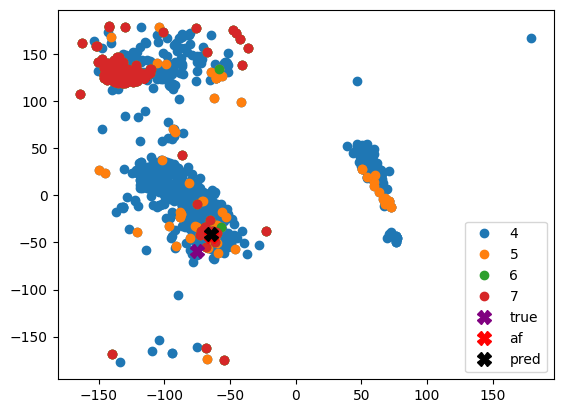

In [17]:
for X,xres,af,y in testloader:
    with torch.no_grad():
        X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
        logits = model(X, xres, af)
    break
plot(X, y, 6, logits, af=af)

## LSTM Across Protein

In [ ]:
class MultiProteinDataset(Dataset): # dont use with DataLoader
    def __init__(self, protein_ids, batch_size, weights_file, device):
        # self.path = path
        # self.ids = [f.name.split('.')[0] for f in path.iterdir() if f.is_file()]
        self.ids = protein_ids
        self.proteinloaders = {id:DataLoader(ProteinDataset(id, path), batch_size=batch_size, shuffle=False) for id in self.ids}
        self.pretrained = LSTMNet().to(device)
        self.pretrained.eval()
        load_model(self.pretrained, weights_file)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        encs = []
        ys = []
        with torch.no_grad():
            for X,xres,y in self.proteinloaders[self.ids[i]]:
                # enc = self.pretrained(X.to(device), xres.to(device))
                enc = self.pretrained.get_encoding(X.to(device), xres.to(device))
                encs.append(enc)
                ys.append(y)
        encs = torch.cat(encs)
        ys = torch.cat(ys)
        return encs.unsqueeze(0), ys
    def get_data(self, i):
        Xs = []
        ys = []
        with torch.no_grad():
            for X,xres,y in self.proteinloaders[self.ids[i]]:
                Xs.append(X)
                ys.append(y)
        Xs = torch.cat(Xs)
        ys = torch.cat(ys)
        return Xs, ys

In [ ]:
device = 'cuda:0'
trainset = MultiProteinDataset(train, 512, '/home/musa/protein-dihedral-visualization/ml_data/best_model_xres_h32_nl1_mlp20_dropout30_1.7k.pt', device)
testset = MultiProteinDataset(test, 512, '/home/musa/protein-dihedral-visualization/ml_data/best_model_xres_h32_nl1_mlp20_dropout30_1.7k.pt', device)
# trainloader = DataLoader(trainset, batch_size=1, shuffle=False)
# testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
i = 0
X_data,y = testset.get_data(i)
X,y = testset[i]
plot(X_data, y, 0, X.squeeze(0))

In [ ]:
class LSTMNet_P2(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = 276
        self.h = 4
        nl = 2
        p_drop = 0.0
        mlp_h = 8
        self.lstm = nn.LSTM(self.input, self.h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.fc = nn.Linear(self.h*2, 2)
        # self.dropout = nn.Dropout(0.3)
        # self.fc2 = nn.Linear(mlp_h, 2)

    def forward(self, x):
        x, (h,c) = self.lstm(x) # keep concatenated hidden states from last layer of each direction for all timesteps
        x = x.squeeze(0) # turn sequence dim into batch dim (1, L, h) -> (L, h)
        x = DataLoader(TensorDataset(x), batch_size=512, shuffle=False) # split into batches in case protein is too long
        logits = []
        for X in x:
            X = self.fc(F.relu(X[0]))
            logits.append(X)
            # logits.append(self.fc2(F.relu(X)))
        return torch.cat(logits)
model = nn.DataParallel(LSTMNet_P2()).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # try lower learning rate
sum([p.numel() for p in model.parameters()])

In [ ]:
X,y = trainset[0]
model(X.to(device)).shape

In [ ]:
train_losses = []
test_losses = []
lowest_test_loss = float('inf')
writer = SummaryWriter('tensorboard2')
for epoch in (pbar := tqdm(range(1500))):
    losses = []
    model.train()
    for X,y in trainset:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,y in testset:
        with torch.no_grad():
            X,y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))
    if test_losses[-1] < lowest_test_loss:
        lowest_test_loss = test_losses[-1]
        save_model(model, 'ml_data/best_model_p2.pt')
    writer.add_scalars('Loss', {
        'train': train_losses[-1],
        'test': test_losses[-1]
    }, epoch)
    writer.flush()

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})
writer.close()

In [ ]:
i = 0
X_data,y = testset.get_data(i)
X,y = testset[i]
logits = model(X.to(device))
plot(X_data, y, 4, X.squeeze(0), logits.squeeze(0))

In [ ]:
model(X.to(device)).shape

# KDE Plots

In [12]:
from scipy.stats import gaussian_kde
from lib.utils import find_kdepeak_af

def get_kdepeak(x, af):
    kdews = [1,32,64,128]
    Xi = x.cpu().numpy().copy()
    kdes = []
    af = pd.DataFrame(af, columns=['phi', 'psi'])
    for i in range(Xi.shape[0]):
        mask = (Xi[i,0] == 0) & (Xi[i,1] == 0)
        Xi[i,:,mask] = np.nan
        x1 = Xi[i,:,s[0]:s[1]]
        x1 = x1[:,~np.isnan(x1).any(axis=0)]
        w1 = np.full(x1.shape[1], kdews[0])
        x2 = Xi[i,:,s[1]:s[2]]
        x2 = x2[:,~np.isnan(x2).any(axis=0)]
        w2 = np.full(x2.shape[1], kdews[1])
        x3 = Xi[i,:,s[2]:s[3]]
        x3 = x3[:,~np.isnan(x3).any(axis=0)]
        w3 = np.full(x3.shape[1], kdews[2])
        x4 = Xi[i,:,s[3]:]
        x4 = x4[:,~np.isnan(x4).any(axis=0)]
        w4 = np.full(x4.shape[1], kdews[3])

        afi = af.loc[af.index == i]

        x = np.concatenate([x1,x2,x3,x4], axis=1)
        w = np.concatenate([w1,w2,w3,w4])
        phi_psi_dist = pd.DataFrame(np.concatenate([x,w.reshape(1,-1)]).T, columns=['phi', 'psi', 'weight'])


        if x.shape[1] == 0:
            kdes.append(np.full(2, np.nan))
            continue
        try:
            kdepeak = find_kdepeak_af(phi_psi_dist, None, afi).values
            print('KDEPEAK', kdepeak)
        except Exception as e:
            print(e)
            kdes.append(np.full(2, np.nan))
            continue
        kdes.append(kdepeak)
    return np.stack(kdes)

# Eucledian distance
def diff(x1, x2):
    d = np.abs(x1 - x2)
    return np.minimum(d, 360-d)

In [21]:
model = nn.DataParallel(LSTMNet().to(device))
load_model(model, 'ml_data/best_model.pt')
model.eval()
preds = []
true = []
loss = []

model.eval()
for X,xres,af,y in tqdm(testloader):
    with torch.no_grad():
        X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
        logits = model(X, xres, af)
        lossi = criterion(logits, y)
        loss.append(lossi.item())
        preds.append(logits.cpu().numpy())
        true.append(y.cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)
loss = np.mean(loss)
loss

100%|██████████| 50/50 [00:00<00:00, 57.96it/s]


In [16]:
af_preds = []
af_loss = []
for X,xres,af,y in tqdm(testloader):
    af_lossi = criterion(af, y)
    af_loss.append(af_lossi.item())
    af_preds.append(af.numpy())
af_preds = np.concatenate(af_preds)
af_loss = np.mean(af_loss)
af_loss

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 48.08it/s] 


465.0904748535156

In [ ]:
kdes = []
kdes_loss = []
for X,xres,af,y in tqdm(testloader):
    kde = get_kdepeak(X, af)
    kde_lossi = criterion(torch.Tensor(kde), y)
    kdes.append(kde)
    kdes_loss.append(kde_lossi.item())
kdes = np.concatenate(kdes)
# torch.save(kdes, 'ml_data/kdes.pt')

In [14]:
kdes = torch.load('ml_data/kdes.pt')

In [22]:
# preds_dist = np.sqrt(diff(preds[:,0], true[:,0])**2 + diff(preds[:,1], true[:,1])**2)
kdes_dist = np.sqrt(diff(kdes[:,0], true[:,0])**2 + diff(kdes[:,1], true[:,1])**2)
kdes_dist = kdes_dist[~np.isnan(kdes_dist)]
af_dist = np.sqrt(diff(af_preds[:,0], true[:,0])**2 + diff(af_preds[:,1], true[:,1])**2)
# print('preds', preds_dist.mean(), preds_dist.std(), preds_dist.sum())
print('kdes', kdes_dist.mean(), kdes_dist.std(), kdes_dist.sum())
print('af', af_dist.mean(), af_dist.std(), af_dist.sum())

kdes 16.52297508759619 29.058650449251445 414098.80164533574
af 15.99634 25.783659 402771.84


         preds_dist     kdes_dist       af_dist
count  25179.000000  25179.000000  25179.000000
mean      21.030497     28.477240     15.996340
std       28.229250     50.171017     25.784172
min        0.064466      0.015532      0.077572
25%        6.588028      4.117170      5.365034
50%       12.232864      8.047791      9.319931
75%       22.684220     19.135556     15.966390
max      245.958557    247.853302    250.691498


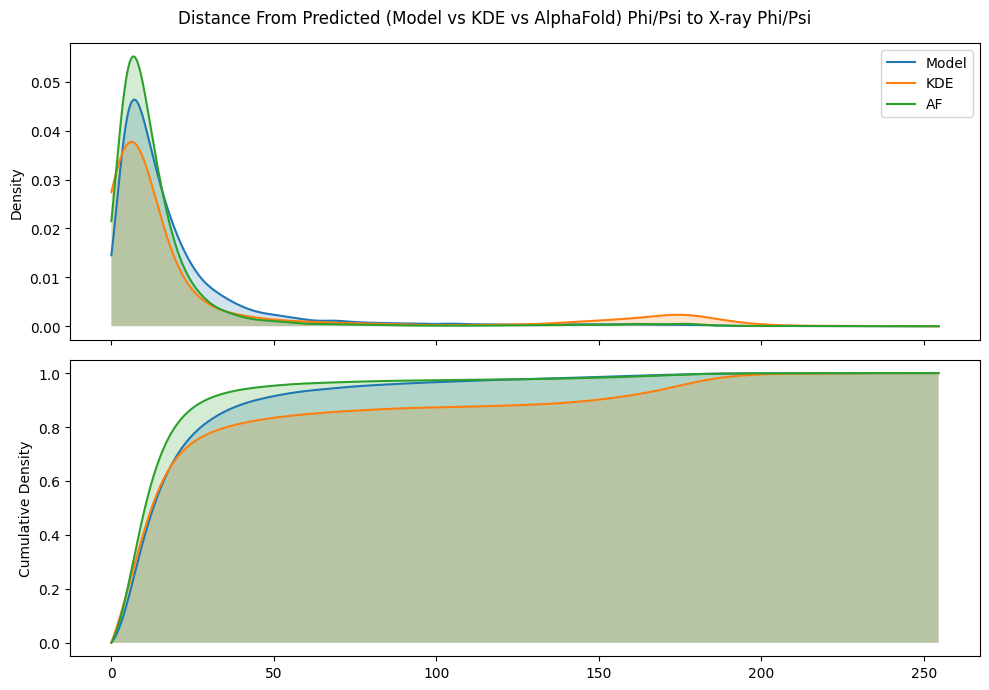

In [316]:
preds_dist = np.sqrt(diff(preds[:,0], true[:,0])**2 + diff(preds[:,1], true[:,1])**2)
kdes_dist = np.sqrt(diff(kdes[:,0], true[:,0])**2 + diff(kdes[:,1], true[:,1])**2)
af_dist = np.sqrt(diff(af_preds[:,0], true[:,0])**2 + diff(af_preds[:,1], true[:,1])**2)
preds_dist[np.where(np.isnan(kdes_dist))] = np.nan
af_dist[np.where(np.isnan(kdes_dist))] = np.nan

df = pd.DataFrame({'preds_dist': preds_dist, 'kdes_dist': kdes_dist, 'af_dist': af_dist})
print(df.describe())
# sns.kdeplot(data=df, x='preds_dist', fill=True, label='preds')
# sns.kdeplot(data=df, x='kdes_dist', fill=True, label='kdes')
# m = max(df.preds_dist.max(), df.kdes_dist.max())
m = np.sqrt(180**2 + 180**2)
fig, axes = plt.subplots(2, 1, figsize=(10,7), sharex=True)

kde = gaussian_kde(df.preds_dist.dropna().values, bw_method=0.1)
x = np.linspace(0, m, 10000)
p = kde(x)
c = np.cumsum(p) / np.sum(p)
axes[0].plot(x, p, label='Model')
axes[0].fill_between(x, 0, p, alpha=0.2)
axes[1].plot(x, c, label='Model')
axes[1].fill_between(x, 0, c, alpha=0.2)

kde = gaussian_kde(df.kdes_dist.dropna().values)
x = np.linspace(0, m, 10000)
p = kde(x)
c = np.cumsum(p) / np.sum(p)
axes[0].plot(x, p, label='KDE')
axes[0].fill_between(x, 0, p, alpha=0.2)
axes[1].plot(x, c, label='KDE')
axes[1].fill_between(x, 0, c, alpha=0.2)

kde = gaussian_kde(df.af_dist.dropna().values)
x = np.linspace(0, m, 10000)
p = kde(x)
c = np.cumsum(p) / np.sum(p)
axes[0].plot(x, p, label='AF')
axes[0].fill_between(x, 0, p, alpha=0.2)
axes[1].plot(x, c, label='AF')
axes[1].fill_between(x, 0, c, alpha=0.2)

axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].set_ylabel('Cumulative Density')

fig.suptitle('Distance From Predicted (Model vs KDE vs AlphaFold) Phi/Psi to X-ray Phi/Psi')
plt.tight_layout()

In [ ]:
model = nn.DataParallel(LSTMNet().to(device))
load_model(model, 'ml_data/best_model_h32_nl1_mlp12_dropout_1.7k.pt')
model.eval();

In [ ]:
X,y = next(iter(testloader))
model.eval()
with torch.no_grad():
    logits = model(X.to(device))
kdepeak = get_kdepeak(X)

In [ ]:
np.argsort(kdes_dist)[-10:]
# print(kdes_dist[1075], preds_dist[1075])
X,y = testloader.dataset[88]
X = X.unsqueeze(0)
y = y.unsqueeze(0)
with torch.no_grad():
    logits = model(X.to(device))
kdepeak = get_kdepeak(X)

In [ ]:
def plot_pred_and_kde(X, y, i, logits, kdepeak):
    y = y.numpy().copy()
    X = X.numpy().copy()
    logits = logits.cpu().numpy().copy()
    s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
    X[i, :, (X[i,0] == 0) & (X[i,1] == 0)] = np.nan
    
    sns.set_palette("deep")
    fig, ax = plt.subplots(figsize=(7,5))
    sns.scatterplot(x=X[i, 0, s[0]:s[1]], y=X[i, 1, s[0]:s[1]], label='Win 4', edgecolor=None, ax=ax, s=20)
    sns.scatterplot(x=X[i, 0, s[1]:s[2]], y=X[i, 1, s[1]:s[2]], label='Win 5', edgecolor=None, ax=ax, s=20)
    sns.scatterplot(x=X[i, 0, s[2]:s[3]], y=X[i, 1, s[2]:s[3]], label='Win 6', edgecolor=None, ax=ax, s=20)
    sns.scatterplot(x=X[i, 0, s[3]:    ], y=X[i, 1, s[3]:    ], label='Win 7', edgecolor=None, ax=ax, s=20)
    
    sns.set_palette("bright")
    sns.scatterplot(x=[y[i,0]], y=[y[i,1]], marker='X', label='X-Ray', s=100, linewidth=1.5, ax=ax)
    sns.scatterplot(x=[logits[i,0]], y=[logits[i,1]], marker='X', label='Model Prediction',  s=100, linewidth=1.5, ax=ax)
    sns.scatterplot(x=[kdepeak[i,0]], y=[kdepeak[i,1]], marker='X', label='PDBMine KDE Prediction',  s=100, linewidth=1.5, ax=ax)

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    ax.legend()
    ax.set_title('PDBMine KDE Prediction vs Model Prediction vs X-Ray Phi/Psi for one kmer')
    plt.tight_layout()
# 15,16, 30, 38
plot_pred_and_kde(X, y, 0, logits, kdepeak)